In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

%matplotlib inline
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [2]:
df = pd.read_csv('telco.csv')
df.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,7043.0,0.162147,0.368612,0.00,0.0,0.00,0.00,1.00
tenure,7043.0,32.371149,24.559481,0.00,9.0,29.00,55.00,72.00
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.5,70.35,89.85,118.75


In [5]:
df.loc[df.Churn=='No','Churn'] = 0
df.loc[df.Churn=='Yes','Churn'] = 1
df['Churn'] = df.Churn.astype(np.int64)

### Exploratory Data Analysis

In [6]:
for val in df["TotalCharges"]:
    try:
        float(val)
    except:
        print('>',val,'<')

>   <
>   <
>   <
>   <
>   <
>   <
>   <
>   <
>   <
>   <
>   <


In [7]:
df.loc[pd.to_numeric(df['TotalCharges'], errors='coerce').isnull(),'TotalCharges'] = np.nan
df = df.dropna()
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

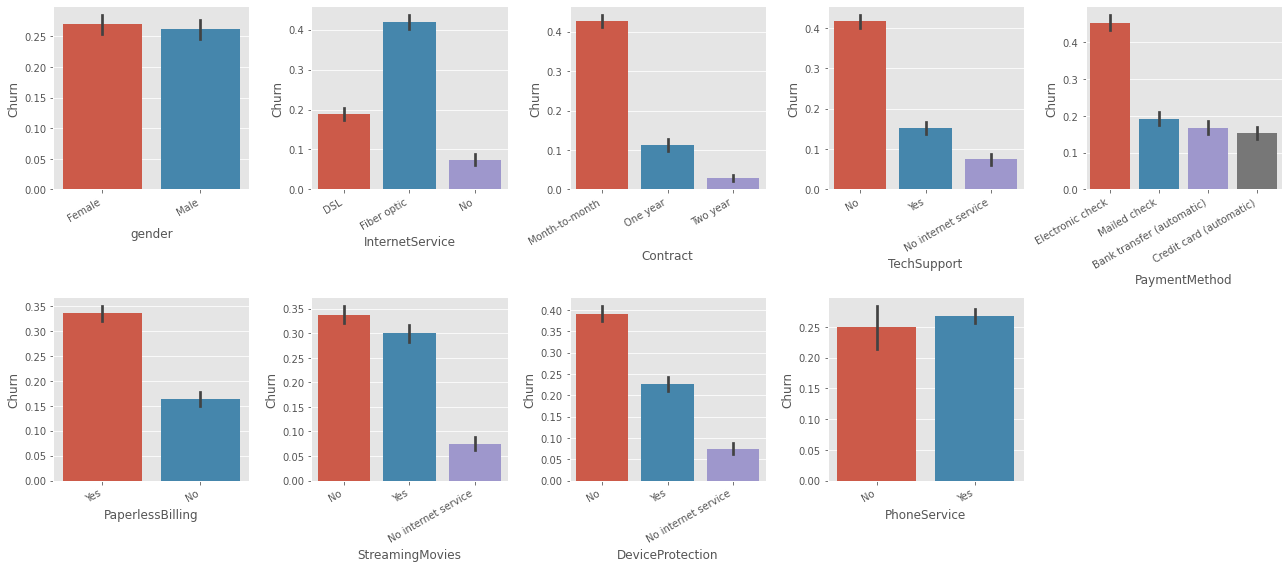

In [8]:
plt.figure(figsize=(18, 8))
for num,col in enumerate(['gender','InternetService','Contract','TechSupport','PaymentMethod',
                          'PaperlessBilling','StreamingMovies','DeviceProtection','PhoneService'],1):
    plt.subplot(2, 5, num)
    sns.barplot(df[col], df.Churn)
    plt.xticks(rotation=30, ha='right')
    plt.tight_layout();

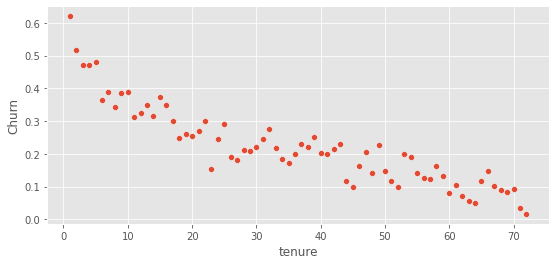

In [9]:
plot_tenure = df.groupby('tenure').Churn.mean().reset_index()

plt.figure(figsize=(9, 4))
sns.scatterplot(x='tenure', y='Churn', data=plot_tenure);

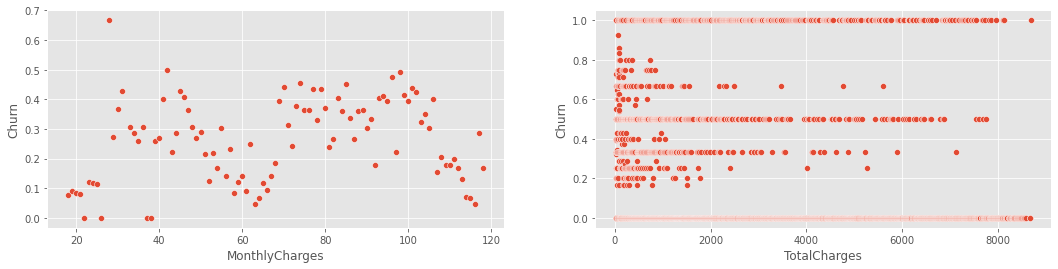

In [10]:
dfCopy = df.copy()

plt.figure(figsize=(18, 4))

dfCopy['MonthlyCharges'] = dfCopy['MonthlyCharges'].astype(int)
plot_monthly = dfCopy.groupby('MonthlyCharges').Churn.mean().reset_index()
dfCopy['TotalCharges'] = dfCopy['TotalCharges'].astype(int)
plot_total = dfCopy.groupby('TotalCharges').Churn.mean().reset_index()

plt.subplot(1, 2, 1)
sns.scatterplot(x='MonthlyCharges', y='Churn', data=plot_monthly)

plt.subplot(1, 2, 2)
sns.scatterplot(x='TotalCharges', y='Churn', data=plot_total);

### Feature Engineering

In [11]:
from sklearn.cluster import KMeans

In [12]:
def order_cluster(cluster_field_name, target_field_name, df, ascending=False):
    df_idx = df.groupby(cluster_field_name)[target_field_name].mean().sort_values(ascending=ascending).reset_index()
    df_idx['index'] = df_idx.index
    df_last = pd.merge(df, df_idx[[cluster_field_name,'index']], on=cluster_field_name)
    df_last = df_last.drop([cluster_field_name], axis=1)
    df_last = df_last.rename(columns={'index':cluster_field_name})
    return df_last

#### Tenure

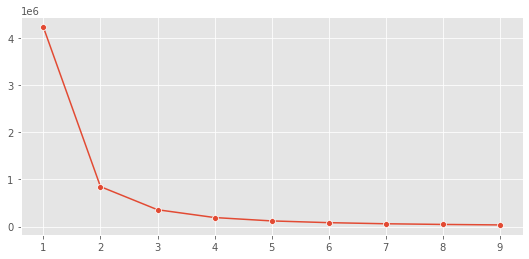

In [13]:
wcss = []
for k in range(1,10):
    model = KMeans(n_clusters = k, max_iter=1000, random_state = 42).fit(df[['tenure']])
    wcss.append(model.inertia_)

plt.figure(figsize=(9,4))
sns.lineplot(range(1,10), wcss, marker = 'o');

In [14]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(df[['tenure']])
df['TenureCluster'] = kmeans.predict(df[['tenure']])

df = order_cluster('TenureCluster', 'tenure', df, True)

df.groupby('TenureCluster').tenure.describe()

,count,mean,std,min,25%,50%,75%,max
TenureCluster,,,,,,,,
0,2930.0,7.830717,6.220431,1.0,2.0,6.0,13.0,21.0
1,1929.0,34.792120,8.297679,22.0,27.0,35.0,42.0,49.0
2,2173.0,63.475380,7.172433,50.0,57.0,65.0,70.0,72.0


In [15]:
df['TenureCluster'] = df["TenureCluster"].replace({0:'Low',1:'Mid',2:'High'})

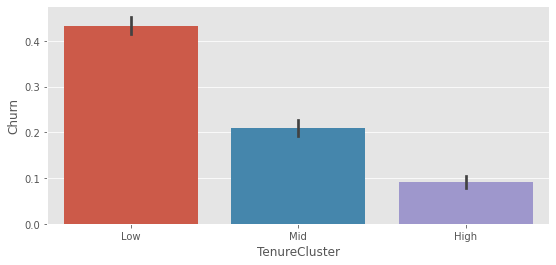

In [16]:
plt.figure(figsize=(9,4))
sns.barplot(df.TenureCluster, df.Churn);

#### Monthly Charge

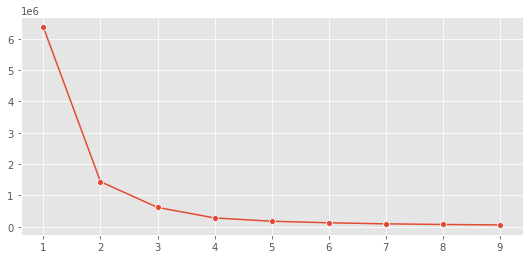

In [17]:
wcss = []
for k in range(1,10):
    model = KMeans(n_clusters = k, max_iter=1000, random_state = 42).fit(df[['MonthlyCharges']])
    wcss.append(model.inertia_)

plt.figure(figsize=(9,4))
sns.lineplot(range(1,10), wcss, marker = 'o');

In [18]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(df[['MonthlyCharges']])
df['MonthlyChargesCluster'] = kmeans.predict(df[['MonthlyCharges']])

df = order_cluster('MonthlyChargesCluster', 'MonthlyCharges', df, True)

df.groupby('MonthlyChargesCluster').MonthlyCharges.describe()

,count,mean,std,min,25%,50%,75%,max
MonthlyChargesCluster,,,,,,,,
0,1886.0,23.389608,5.666778,18.25,19.8,20.40,25.05,42.40
1,2237.0,61.644502,10.451979,42.60,51.8,61.55,70.70,77.85
2,2909.0,94.069938,10.337638,77.90,85.1,93.90,101.95,118.75


In [19]:
df['MonthlyChargesCluster'] = df["MonthlyChargesCluster"].replace({0:'Low',1:'Mid',2:'High'})

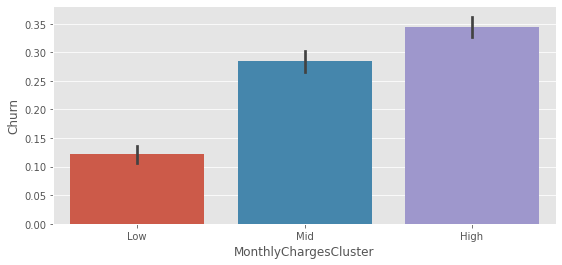

In [20]:
plt.figure(figsize=(9,4))
sns.barplot(df.MonthlyChargesCluster, df.Churn);

#### Total Charge

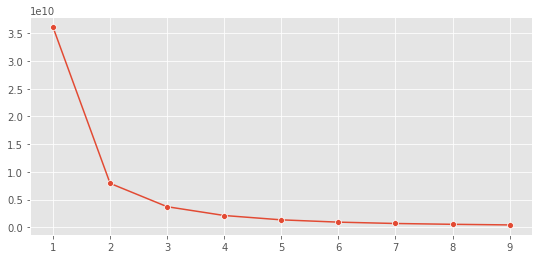

In [21]:
wcss = []
for k in range(1,10):
    model = KMeans(n_clusters = k, max_iter=1000, random_state = 42).fit(df[['TotalCharges']])
    wcss.append(model.inertia_)

plt.figure(figsize=(9,4))
sns.lineplot(range(1,10), wcss, marker = 'o');

In [22]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(df[['TotalCharges']])
df['TotalChargesCluster'] = kmeans.predict(df[['TotalCharges']])

df = order_cluster('TotalChargesCluster', 'TotalCharges', df, True)

df.groupby('TotalChargesCluster').TotalCharges.describe()

,count,mean,std,min,25%,50%,75%,max
TotalChargesCluster,,,,,,,,
0,4201.0,699.062378,583.781087,18.80,163.600,547.65,1164.050,2025.1
1,1599.0,3331.100719,814.768166,2028.80,2603.625,3268.05,4021.375,4837.6
2,1232.0,6325.468831,989.723570,4839.15,5515.325,6182.25,7063.550,8684.8


In [23]:
df['TotalChargesCluster'] = df["TotalChargesCluster"].replace({0:'Low',1:'Mid',2:'High'})

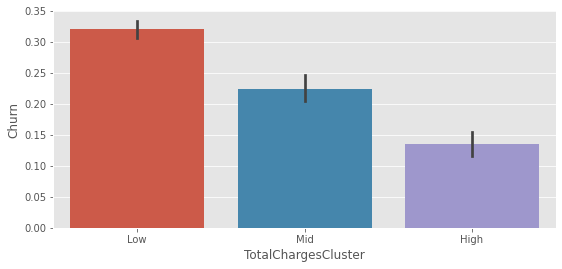

In [24]:
plt.figure(figsize=(9,4))
sns.barplot(df.TotalChargesCluster, df.Churn);

### Categorical Columns

In [25]:
from sklearn.preprocessing import LabelEncoder

dfDummy = df.copy()

le = LabelEncoder()
dummy_columns = []

for column in dfDummy.columns:
    if dfDummy[column].dtype == object and column != 'customerID':
        if dfDummy[column].nunique() == 2:
            #apply Label Encoder for binary ones
            dfDummy[column] = le.fit_transform(dfDummy[column]) 
        else:
            dummy_columns.append(column)

#apply get dummies for selected columns
dfDummy = pd.get_dummies(data = dfDummy, columns = dummy_columns)

In [26]:
dfDummy.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,...,PaymentMethod_Mailed check,TenureCluster_High,TenureCluster_Low,TenureCluster_Mid,MonthlyChargesCluster_High,MonthlyChargesCluster_Low,MonthlyChargesCluster_Mid,TotalChargesCluster_High,TotalChargesCluster_Low,TotalChargesCluster_Mid
0,7590-VHVEG,0,0,1,0,1,0,1,29.85,29.85,...,0,0,1,0,0,1,0,0,1,0
1,6713-OKOMC,0,0,0,0,10,0,0,29.75,301.90,...,1,0,1,0,0,1,0,0,1,0
2,7469-LKBCI,1,0,0,0,16,1,0,18.95,326.80,...,0,0,1,0,0,1,0,0,1,0


In [27]:
dfDummy.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'PaperlessBilling', 'MonthlyCharges',
       'TotalCharges', 'Churn', 'MultipleLines_No',
       'MultipleLines_No phone service', 'MultipleLines_Yes',
       'InternetService_DSL', 'InternetService_Fiber optic',
       'InternetService_No', 'OnlineSecurity_No',
       'OnlineSecurity_No internet service', 'OnlineSecurity_Yes',
       'OnlineBackup_No', 'OnlineBackup_No internet service',
       'OnlineBackup_Yes', 'DeviceProtection_No',
       'DeviceProtection_No internet service', 'DeviceProtection_Yes',
       'TechSupport_No', 'TechSupport_No internet service', 'TechSupport_Yes',
       'StreamingTV_No', 'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No', 'StreamingMovies_No internet service',
       'StreamingMovies_Yes', 'Contract_Month-to-month', 'Contract_One year',
       'Contract_Two year', 'PaymentMethod_Bank transfer (automatic)',
      

In [28]:
all_columns = []
for column in dfDummy.columns:
    column = column.replace(' ', '').replace('(', '_').replace(')', '').replace('-', '')
    all_columns.append(column)

dfDummy.columns = all_columns

### Logistic Regresyon

In [29]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [30]:
glm_columns = 'gender'

for column in dfDummy.columns:
    if column not in ['Churn','customerID','gender']:
        glm_columns = glm_columns + ' + ' + column

In [31]:
glm_model = smf.glm(formula='Churn ~ {}'.format(glm_columns), data=dfDummy, family=sm.families.Binomial())
res = glm_model.fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Churn   No. Observations:                 7032
Model:                            GLM   Df Residuals:                     7002
Model Family:                Binomial   Df Model:                           29
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2902.2
Date:                Fri, 09 Oct 2020   Deviance:                       5804.4
Time:                        14:29:00   Pearson chi2:                 7.59e+03
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


In [32]:
res.pvalues[res.pvalues < 0.05].sort_values()

tenure                                2.077478e-14
Contract_Monthtomonth                 7.763748e-11
PaperlessBilling                      3.972532e-06
Contract_Twoyear                      4.275211e-05
PaymentMethod_Electroniccheck         2.222075e-04
OnlineSecurity_No                     2.538346e-03
TechSupport_No                        3.502988e-03
TenureCluster_High                    5.850164e-03
InternetService_DSL                   7.146496e-03
SeniorCitizen                         1.000184e-02
OnlineSecurity_Nointernetservice      2.806118e-02
TechSupport_Nointernetservice         2.806118e-02
OnlineBackup_Nointernetservice        2.806118e-02
StreamingTV_Nointernetservice         2.806118e-02
StreamingMovies_Nointernetservice     2.806118e-02
DeviceProtection_Nointernetservice    2.806118e-02
InternetService_No                    2.806118e-02
OnlineBackup_No                       3.934375e-02
dtype: float64

In [33]:
np.exp(res.params).sort_values()

Contract_Twoyear                        0.543977
InternetService_DSL                     0.544662
TotalChargesCluster_Low                 0.770352
InternetService_No                      0.818498
OnlineBackup_Nointernetservice          0.818498
StreamingMovies_Nointernetservice       0.818498
TechSupport_Nointernetservice           0.818498
DeviceProtection_Nointernetservice      0.818498
StreamingTV_Nointernetservice           0.818498
OnlineSecurity_Nointernetservice        0.818498
TenureCluster_Mid                       0.869228
Dependents                              0.876372
TenureCluster_Low                       0.880687
MultipleLines_No                        0.893119
tenure                                  0.937990
StreamingMovies_No                      0.940055
StreamingTV_No                          0.940619
PaymentMethod_Creditcard_automatic      0.946933
PaymentMethod_Mailedcheck               0.953731
MonthlyCharges                          0.966074
gender              

### XGBoosting

In [34]:
import xgboost as xgb
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import KFold, cross_val_score, train_test_split

In [35]:
X = dfDummy.drop(['Churn','customerID'],axis=1)
y = dfDummy.Churn

In [36]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
xgb_model = xgb.XGBClassifier(max_depth=5, learning_rate=0.08, objective= 'binary:logistic', n_jobs=-1).fit(x_train, y_train)

print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(xgb_model.score(x_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(xgb_model.score(x_test, y_test)))

Accuracy of XGB classifier on training set: 0.84
Accuracy of XGB classifier on test set: 0.81


In [38]:
y_pred = xgb_model.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.90      0.87      1043
           1       0.65      0.53      0.59       364

    accuracy                           0.81      1407
   macro avg       0.75      0.72      0.73      1407
weighted avg       0.80      0.81      0.80      1407



In [39]:
from xgboost import plot_tree, plot_importance

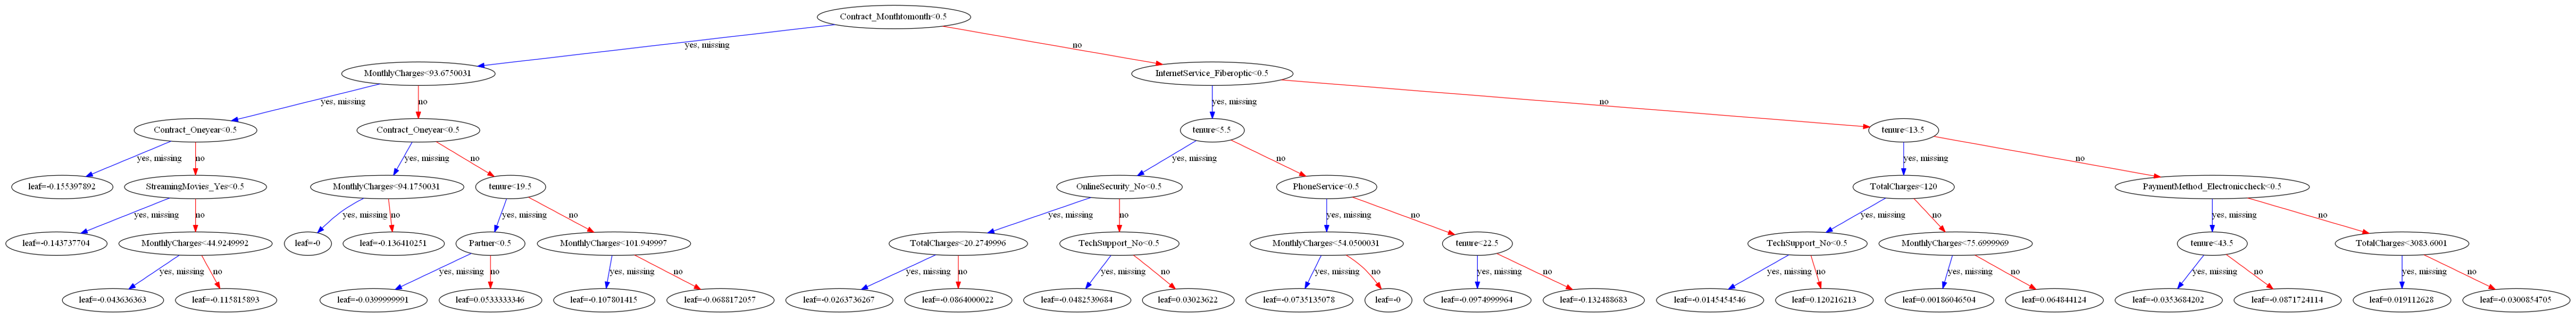

In [40]:
fig, ax = plt.subplots(figsize=(100,100))
plot_tree(xgb_model, ax=ax);

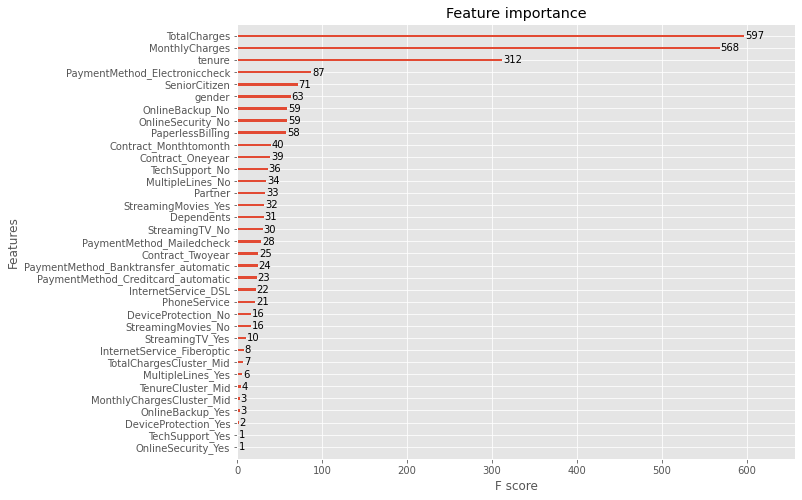

In [41]:
fig, ax = plt.subplots(figsize=(10,8))
plot_importance(xgb_model, ax=ax);

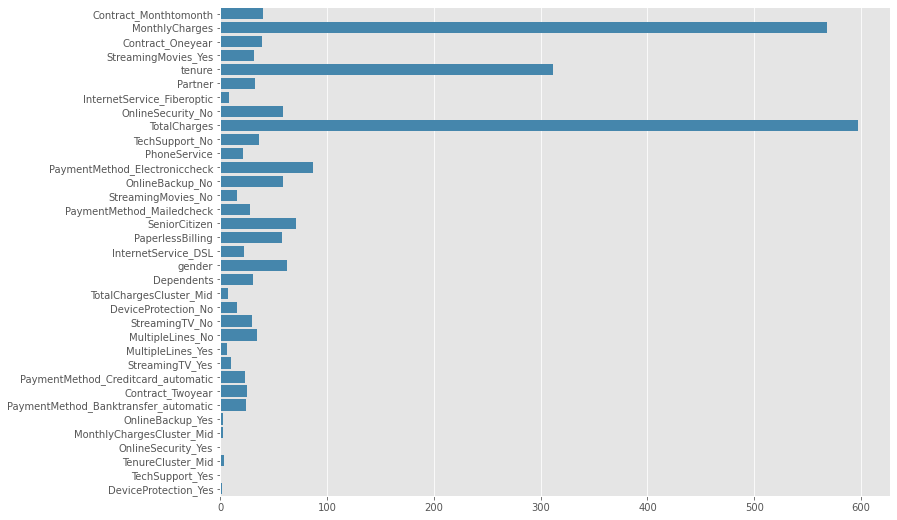

In [42]:
#Available importance_types = [‘weight’, ‘gain’, ‘cover’, ‘total_gain’, ‘total_cover’]
xgb_gain = xgb_model.get_booster().get_score(importance_type= 'weight')

plt.figure(figsize=(12,9))
sns.barplot(list(xgb_gain.values()), list(xgb_gain.keys()), color = '#348ABD');

In [43]:
dfDummy['proba'] = xgb_model.predict_proba(dfDummy[x_train.columns])[:,1]

In [44]:
dfDummy[['customerID','proba']].head()

,customerID,proba
0,7590-VHVEG,0.711881
1,6713-OKOMC,0.226756
2,7469-LKBCI,0.008289
3,8779-QRDMV,0.946492
4,1680-VDCWW,0.053101
